In [1]:
import librosa
import numpy as np
import pandas as pd
import os
import sys
from torch.utils.data import Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch

from sklearn.model_selection import train_test_split

In [2]:

count = 0
all_data = []
all_label = []
for subdir, dirs, files in os.walk("BDLib-2"):
    for file in files:
        filepath = os.path.join(subdir, file)
        if file.endswith('.DS_Store'):
            continue  # Skip this file
        # print(filepath)
        if 'airplane' in filepath:
            label = 0
        if 'alarms' in filepath:
            label = 1
        if 'applause' in filepath:
            label = 2
        if 'birds' in filepath:
            label = 3
        if 'dogs' in filepath:
            label = 4
        if 'motorcycles' in filepath:
            label = 5
        if 'rain' in filepath:
            label = 6
        if 'rivers' in filepath:
            label = 7
        if 'seawaves' in filepath:
            label = 8
        if 'thunders' in filepath:
            label = 9


        wav, sr = librosa.load(filepath, sr=44100)
        step_num = int((44100 * 1) / 2)

        ind = 0
        # print("shape of each wav" + str(wav.shape))
        while ind + step_num + step_num <= wav.shape[0]:  #add one second, smaller than the total amount of second
            frame = wav[ind:ind+step_num+step_num]        #frame of 1 second
            ind = ind + step_num                          #go on for half a second
            count = count + 1                             #
            hop_length = 44100 // 100                     #for every 10ms

            # melspec = librosa.feature.melspectrogram(y=frame, sr=44100, hop_length=hop_length)
            melspec = librosa.feature.melspectrogram(y=frame, sr=44100, hop_length=hop_length, n_mels = 64)
            melspec = librosa.power_to_db(melspec, ref=np.max)
            m1 = np.mean(melspec,axis = 1) # 128 X 1
            m2 = np.std(melspec,axis = 1)  # 128 X 1

            feature_list = [m1,m2] 
            features = np.concatenate([feature.flatten() for feature in feature_list])

            all_data.append(features)
            all_label.append(label)

print(count)

3420


In [3]:
import json
import numpy as np


for i in range(3420):
  all_data[i] = all_data[i].tolist()

#print(type(all_data[0]))


with open('dataNew.json', 'w') as json_file:
  json.dump(all_data, json_file, indent=4)

In [4]:
with open('label.json', 'w') as json_file:
  json.dump(all_label, json_file, indent=4)

print(len(all_data[0]))

128


In [5]:
X_train, X_test, y_train, y_test = train_test_split(all_data, all_label, test_size=0.3, random_state=42, shuffle = True) #y is the label, x is the input
with open('Xtrain.json', 'w') as json_file:
    json.dump(X_train, json_file, indent=4)
with open('Xtest.json', 'w') as json_file:
    json.dump(X_test, json_file, indent=4)
with open('Ytrain.json', 'w') as json_file:
    json.dump(y_train, json_file, indent=4)
with open('Ytest.json', 'w') as json_file:
    json.dump(y_test, json_file, indent=4)
print(len(X_train))


2394


In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='linear'))
clf.fit(X_train, y_train)
sum(clf.predict(X_test) == y_test) / len(y_test)

0.9649122807017544

In [7]:
class linear_random_projection:
    def __init__(self,in_dim,out_dim):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.init_projection()

    def init_projection(self):
        self.projection = np.random.normal(0, 1, size=(self.out_dim, self.in_dim))
        self.projection = np.sign(self.projection)
        with open('projection.json', 'w') as json_file:
            json.dump(self.projection.tolist(), json_file, indent=4)
        print(self.projection.shape)

    def encode(self,x):
        # print(self.projection.shape)
        # print(x.shape)
        enc = self.projection @ x
        # print(enc.shape)
        enc = enc.squeeze()
        # print(enc.shape)
        return np.sign(enc)

In [8]:
class hd_model:
    def __init__(self,X_train, X_test, y_train, y_test ,in_dim,out_dim,lr):
        
        scaler = StandardScaler()
        scaler.fit(X_train)
        
        self.X_train = scaler.transform(X_train)
        self.X_test = scaler.transform(X_test)
        self.y_train = y_train
        self.y_test = y_test
        # print("X_train - mean:" + str(np.array(X_train).mean()) + ", \nsum:" + str(np.sum(np.array(X_train))) + ", std:" + str(np.array(X_train).std()) + ", \nsize: " + str(np.array(X_train).size) + ", shape:" + str(self.X_train.shape))
        # print("X_test - mean:" + str(np.array(X_test).mean()) + ", \nsum:" + str(np.sum(np.array(X_test))) + ", std:" + str(np.array(X_test).std()) + ", \nsize: " + str(np.array(X_test).size) + ", shape:" + str(self.X_test.shape))
        # print("self.X_train - mean:" + str(self.X_train.mean()) + ", \nsum:" + str(np.sum(self.X_train)) + ", std:" + str(self.X_train.std()) + ", \nsize: " + str(self.X_train.size) + ", shape:" + str(self.X_train.shape))
        # print("y_train - mean:" + str(np.array(y_train).mean()) + ", \nsum:" + str(np.array(y_train).sum()) + ", std:" + str(np.array(y_train).std())  + ", \nsize: " + str(np.array(y_train).size) + ", shape:" + str(np.array(y_train).shape))
        # print("self.X_test - mean:" + str(self.X_test.mean()) + ", \nsum:" + str(self.X_test.sum()) + ", std:" + str(self.X_test.std()) + ", \nsize: " + str(self.X_test.size) + ", shape:" + str(self.X_test.shape))
        # print("y_test - mean:" + str(np.array(y_test).mean()) + ", \nsum:" + str(np.array(y_test).sum()) + ", std:" + str(np.array(y_test).std()) + ", \nsize: " + str(np.array(y_test).size) + ", shape:" + str(np.array(y_test).shape))
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.lr = lr

        self.encoder = linear_random_projection(self.in_dim,self.out_dim)
        self.class_hvs = np.zeros((10,self.out_dim))
        
        self.train_encs = []
    
    def train_(self):
        n_train = len(self.X_train)
        for i in range(n_train):
            sample = self.X_train[i]
            label = self.y_train[i]
            enc = self.encoder.encode(sample)
            similarities = cosine_similarity(enc.reshape(1, -1), self.class_hvs)[0]
            pred = np.argmax(similarities)
            # print("largest similarity? ")
            # print(np.max(similarities))
            # print(enc.shape)
            # print(np.dot(enc, self.class_hvs[pred]))
            # print(np.linalg.norm(self.class_hvs))
            # print(np.linalg.norm(enc))
            self.class_hvs[label] +=  enc
            self.class_hvs[pred] -= enc
            self.train_encs.append(enc)
        
    
    def test_(self):
        preds = []
                           
        n_test = len(self.X_test)
        for i in range(n_test):
            sample = self.X_test[i]
            label = self.y_test[i]
            enc = self.encoder.encode(sample)
            similarities = cosine_similarity(enc.reshape(1, -1), self.class_hvs)[0]
            pred = np.argmax(similarities)
            preds.append(pred)
        
        print("================================")
        print(accuracy_score(self.y_test, preds))
        print(f1_score(self.y_test, preds, average="weighted"))
        cm = confusion_matrix(self.y_test, preds,labels=[0,1,2,3,4,5,6,7,8,9,10,11])
        # print(cm)
        sns.heatmap(cm, annot=True)
        print("================================")




    def retrain(self):
        for e in range(4):
            count = 0
            # print(e)
            for i in range(len(self.train_encs)):
                enc = self.train_encs[i]
                label = self.y_train[i]
                similarities = cosine_similarity(enc.reshape(1, -1), self.class_hvs)[0]
                pred = np.argmax(similarities)
                if pred != label:
                    self.class_hvs[label] += enc
                    self.class_hvs[pred] -= enc
                    count += 1
            # print(count)

(1000, 128)
(2394, 128)
0.8937621832358674
0.894314872893676


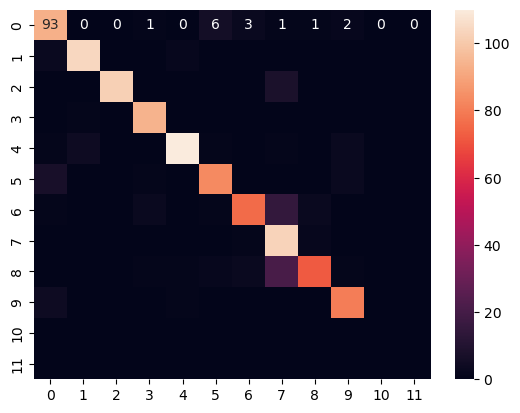

In [41]:
model = hd_model(X_train, X_test, y_train, y_test,128,1000,1)
print(model.X_train.shape)
with open('projection.json', 'w') as json_file:
    json.dump(model.encoder.projection.tolist(), json_file, indent=4)
with open('Xtrain.json', 'w') as json_file:
    json.dump(model.X_train.tolist(), json_file, indent=4)
with open('Xtest.json', 'w') as json_file:
    json.dump(model.X_test.tolist(), json_file, indent=4)
with open('Ytrain.json', 'w') as json_file:
    json.dump(y_train, json_file, indent=4)
with open('Ytest.json', 'w') as json_file:
    json.dump(y_test, json_file, indent=4)
# print(model.encoder.projection.shape)



# c_array_str = "float x_train[] = {\n"
# for row in model.X_train:
#     row_str = ", ".join(map(str, row))
#     c_array_str += f"    {{{row_str}}},\n"
# c_array_str += "};"


# c_array_str = "float x_test[][] = {\n"
# for row in model.X_test:
#     row_str = ", ".join(map(str, row))
#     c_array_str += f"    {{{row_str}}},\n"
# c_array_str += "};"

# c_array_str = "signed char y_train[] = {\n"
# for row in model.y_train:
#     c_array_str += str(row)
#     c_array_str += "\n"
# c_array_str += "};"


# c_array_str = "signed char y_test[] = {\n"
# for row in model.y_test:
#     c_array_str += str(row)
#     c_array_str += "\n"
# c_array_str += "};"

# c_array_str = "  signed char train_encs[DATA_OUT_DIM/8]; \n"

# c_array_str += "signed char class_hvs[CLASS_AMOUNT][DATA_OUT_DIM] = { \n"
# for row in model.class_hvs:
#     row_str = ", ".join(map(str, row))
#     c_array_str += f"    {{{row_str}}},\n"
# c_array_str += "};\n"

# c_array_str += "float X_train[DATA_IN_DIM] = { \n"
# # row_str = ", ".join(map(str, X_train[0]))
# row_str = ", ".join(str(x) for x in X_train[0])
# # for row in X_train[0]:
#     # row_str = ", ".join(map(str, row))
#     # c_array_str += f"    {{{row_str}}},\n"
# c_array_str += "};\n"

# c_array_str += "float X_test[DATA_IN_DIM] = { \n"
# # row_str = ", ".join(map(str, X_test[0]))
# row_str = ", ".join(str(x) for x in X_test[0])
# # for row in X_train[0]:
#     # row_str = ", ".join(map(str, row))
#     # c_array_str += f"    {{{row_str}}},\n"
# c_array_str += "};\n"

# c_array_str += "float y_train = "
# c_array_str += str(y_train[0])
# c_array_str += ";\n" 

# c_array_str += "float y_test = 0; \n"
# c_array_str += str(y_test[0])
# c_array_str += ";\n"

# temp = []
# for i in range(len(model.encoder.projection)):
#     temp2 = []
#     for j in range(len(model.encoder.projection[0])//8):
#         a = 0
#         for k in range(8):
#             a = a * 2
#             if (model.encoder.projection[i][j*8+k] > 0):
#                 a = a + 1
#         temp2.append(a)
#             #print(a)
#     temp.append(temp2)
# c_array_str += "signed char projection[DATA_OUT_DIM][DATA_IN_DIM/8] = {\n"
# for row in temp:
#     row_str = ", ".join(map(str, row))
#     c_array_str += f"    {{{row_str}}},\n"
# c_array_str += "};\n"

# with open('defines.txt', 'w') as file:
#     file.write(c_array_str)




model.train_()
with open('classEncoding.json', 'w') as json_file:
    json.dump(model.class_hvs.tolist(), json_file, indent=4)
model.test_()

0.9346978557504874
0.9345069211494625


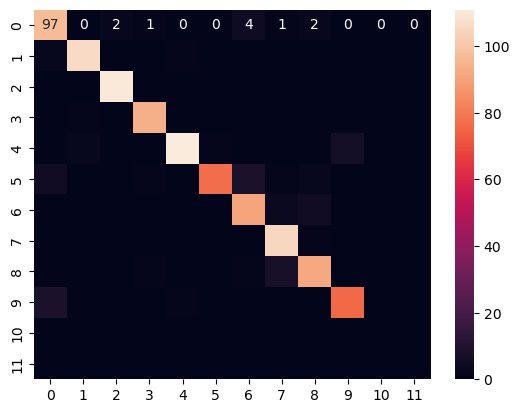

In [42]:
model.retrain()

model.test_()

In [43]:
print(model.X_train.shape)

c_array_str = "  signed char train_encs[DATA_OUT_DIM/8]; \n"

c_array_str += "signed char class_hvs[CLASS_AMOUNT][DATA_OUT_DIM] = { \n"
for row in model.class_hvs:
    row_str = ", ".join(map(str, row))
    c_array_str += f"    {{{row_str}}},\n"
c_array_str += "};\n"

c_array_str += "float X_train[DATA_IN_DIM] = { \n"
c_array_str += ", ".join(map(str, X_train[0]))
# row_str = ", ".join(str(x) for x in X_train[0])
# for row in X_train[0]:
    # row_str = ", ".join(map(str, row))
    # c_array_str += f"    {{{row_str}}},\n"
c_array_str += "};\n"

c_array_str += "float X_test[DATA_IN_DIM] = { \n"
# row_str = ", ".join(map(str, X_test[0]))
# row_str = ", ".join(str(x) for x in X_test[0])
# for row in model.X_train[0]:
# row_str = ", ".join(str(x) for x in row)
# c_array_str += f"    {{{row_str}}},\n"
c_array_str += ", ".join(map(str, X_test[0]))
c_array_str += "};\n"

c_array_str += "float y_train = "
c_array_str += str(model.y_train[0])
c_array_str += ";\n" 

c_array_str += "float y_test = 0; \n"
c_array_str += str(model.y_test[0])
c_array_str += ";\n"

temp = []
for i in range(len(model.encoder.projection)):
    temp2 = []
    for j in range(len(model.encoder.projection[0])//8):
        a = 0
        for k in range(8):
            a = a * 2
            if (model.encoder.projection[i][j*8+k] > 0):
                a = a + 1
        temp2.append(a)
            #print(a)
    temp.append(temp2)
c_array_str += "signed char projection[DATA_OUT_DIM][DATA_IN_DIM/8] = {\n"
for row in temp:
    row_str = ", ".join(map(str, row))
    c_array_str += f"    {{{row_str}}}, "
c_array_str += "};\n"

with open('defines.txt', 'w') as file:
    file.write(c_array_str)



(2394, 128)


In [44]:
model.class_hvs

array([[ 10.,  -6.,  28., ..., -22.,   8., -20.],
       [  4.,  10.,  -8., ...,   4.,   0.,  12.],
       [ 18.,  -4., -14., ...,   0.,  -8.,  -2.],
       ...,
       [ 28.,  10., -26., ...,   6., -10.,   6.],
       [ -4.,  -2.,  44., ...,  24.,  20.,  -2.],
       [ -4.,   4.,  14., ...,  24.,   4.,   4.]])